In [1]:
from individual_players.league_model import (
    add_player_aggregates,
    fit_std_by_sample_size,
)
from individual_players import LeagueModel, build_combined_df

In [2]:
league = "mens"
df = build_combined_df(league)

Dropped 27339 duplicate rows. Maybe you should figure out why they're in here?
Dropped 13923 rows because they had <= 0 possessions. Maybe you should figure out why they're in here?
Found games where a player had multiple lines in the box score. Here's an example
       player_id      value    game_id  team_id  n_possessions
48008      51529  11.538231  400589248     2029      35.944331
48014      51529  11.335017  400589248     2272      65.778125
Dropping 13 bad games


I manually looked at this example. The page on ESPN is just bad ([link](https://www.espn.com/mens-college-basketball/boxscore/_/gameId/400589248)). It has B. Richardson playing for both teams in the box score, but he actually played for High Point.

To deal with that, I'm just gonna drop any games that have players with multiple appearances, it's not that many

# Find SD(game vpp - overall vpp) ~ n_possessions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

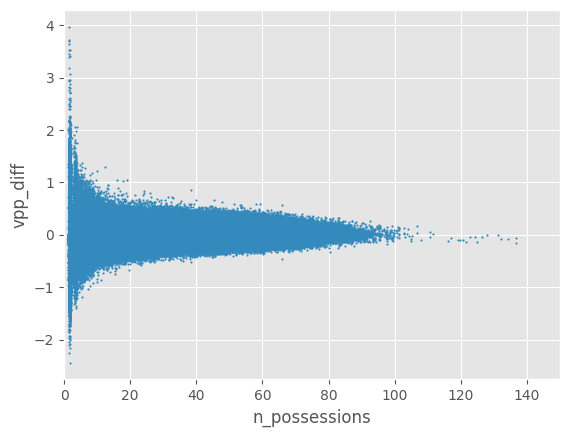

In [4]:
with_player_aggregates, by_player = add_player_aggregates(df)
with_player_aggregates.plot.scatter('n_possessions', 'vpp_diff', s=1)
# There's values hidden both below and above this...might want to strip them out
plt.xlim(0, 150);

Neat, looks like something around 1/x. Transform that so I can make a linear model

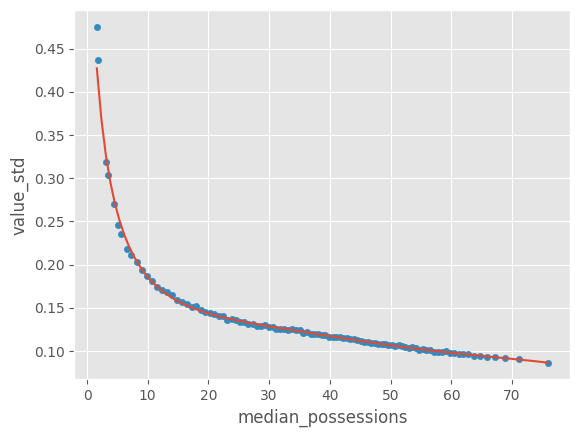

In [5]:
std_by_sample_size, get_vpp_sd = fit_std_by_sample_size(
    with_player_aggregates,
    # inv_power=2,
    # polynomial_power=3,
    inv_power=1,
    polynomial_power=5,
)
std_by_sample_size.plot.scatter('median_possessions', 'value_std');

# Draw the curve of our fit
x = np.linspace(std_by_sample_size.median_possessions.min(), std_by_sample_size.median_possessions.max(), 100)
line_result = get_vpp_sd(x)
plt.plot(x, line_result);

Seems like a pretty good fit. Let's use that

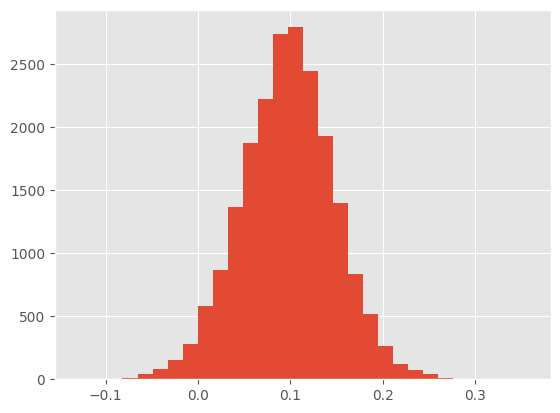

In [6]:
career_vpp = (by_player.total_value / by_player.total_possessions)
career_vpp.hist(bins=30);

In [7]:
vpp_mean = career_vpp.mean()
vpp_var = career_vpp.var()
print(f"{vpp_mean = }\n{vpp_var = }")

vpp_mean = 0.09691070850849016
vpp_var = 0.002531269285860531


In [8]:
model = LeagueModel(
    possessions_to_vpp_std=get_vpp_sd,
    vpp_mean=vpp_mean,
    vpp_variance=vpp_var,
)
model.save(f"models/{league}.pkl")